In [1]:
import os
import pickle
import uuid

import sys
sys.path.append("..")

import pandas as pd

from kgsearch import preprocess, prompts, graph

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFDirectoryLoader, DirectoryLoader



In [2]:
with open('../data/text.pkl', 'rb') as f:
    data = pickle.load(f)

print("Keys:")
print(*data.keys(), sep = "\n")


Keys:
The Advanced Test Reactor.txt
Idaho National Laboratory.txt
Hyman G Rickover January.txt


In [10]:
# Instantiate the text splitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=50,
    chunk_overlap=10,
    length_function=len,
    is_separator_regex=False
)

df = pd.DataFrame()
for key in data.keys():
    # Split the string using the splitter
    _ = pd.DataFrame(splitter.split_text(str(data[key])), columns=['chunk'])
    _['source'] = key
    _['chunk_id'] = [uuid.uuid4().hex for i in range(len(_))]

    df = pd.concat([df, _], ignore_index=True)


In [11]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Function to map NLTK position tags to WordNet position tags
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


[nltk_data] Downloading package wordnet to /home/ryan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ryan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/ryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

df['lamma'] = [' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)]) for text in df.chunk]
df

,chunk,source,chunk_id,lamma
0,b'The Advanced Test Reactor (ATR) is a research,The Advanced Test Reactor.txt,b0f7960e10114fce8233a794b632d020,b'The Advanced Test Reactor ( ATR ) be a research
1,research reactor at the Idaho National,The Advanced Test Reactor.txt,20187b1d0806479abffdf4b37f7793ed,research reactor at the Idaho National
2,"National Laboratory, located east of Arco, Idaho.",The Advanced Test Reactor.txt,c906d8e5044a4609b4ad144eb6e340f6,"National Laboratory , locate east of Arco , Id..."
3,Idaho. This reactor was designed and is used to,The Advanced Test Reactor.txt,e7fda205a8bf464cae4042e33acf2883,Idaho . This reactor be design and be use to
4,used to test nuclear fuels and materials to be,The Advanced Test Reactor.txt,aff033839ed041449612ef6158125347,use to test nuclear fuel and material to be
...,...,...,...,...
1952,on his gravestone.[115] Eleonore passed away on,Hyman G Rickover January.txt,49ef0caaaa1f4f7ab8dfa9cdb89fba17,on his gravestone . [ 115 ] Eleonore pass away on
1953,"away on July 5, 2021, and was buried in Arlington",Hyman G Rickover January.txt,238b2ecf22c94cc3819387d76c97a782,"away on July 5 , 2021 , and be bury in Arlington"
1954,Arlington Cemetery.[116] Rickover is survived by,Hyman G Rickover January.txt,1cb6c9ec0e514e25a474152807dff9d9,Arlington Cemetery . [ 116 ] Rickover be survi...
1955,"by Robert Rickover, his sole son by his first",Hyman G Rickover January.txt,115cd7a194f1435a8023d6270c890c6a,"by Robert Rickover , his sole son by his first"


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample text documents
documents = [
    "Text of document one",
    "Text of document two",
    "Text of another document",
    # Add more documents as needed
]

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Apply the vectorizer to the text documents
tfidf_matrix = vectorizer.fit_transform(df.lamma)


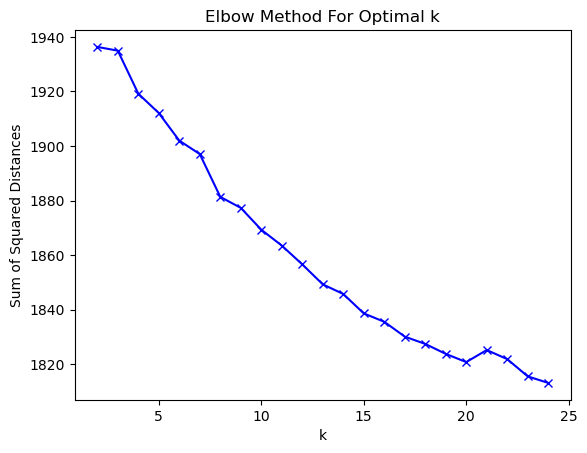

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

# Create the TF-IDF vectorizer and transform the documents
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df.lamma)

# Elbow method to find the optimal number of clusters
sum_of_squared_distances = []
K = range(2, 25)  # Range of k to try
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(tfidf_matrix)
    sum_of_squared_distances.append(km.inertia_)

# Plot the elbow graph
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()


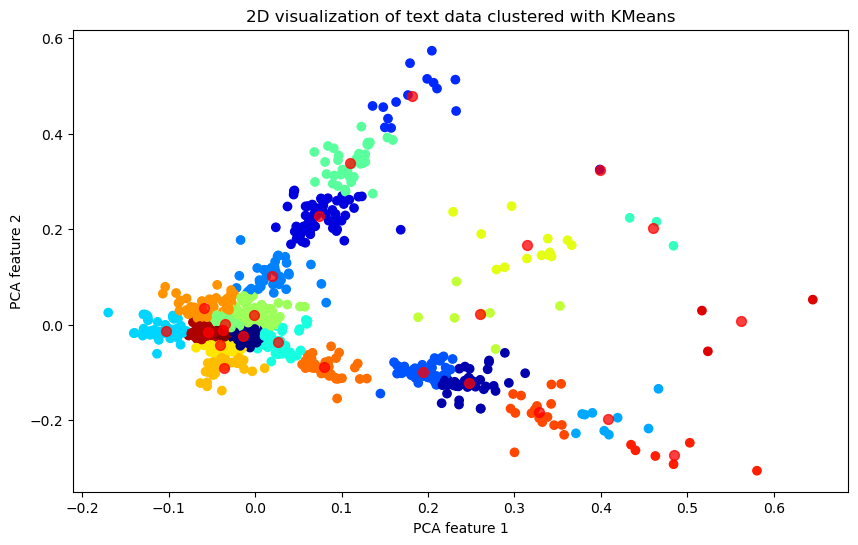

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducing the dimensions of the data to two dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Apply KMeans to the reduced data
kmeans = KMeans(n_clusters=25, random_state=42)
kmeans.fit(reduced_data)
clusters = kmeans.predict(reduced_data)

# Plotting the clustered data
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='jet', marker='o')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75)
plt.title('2D visualization of text data clustered with KMeans')
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')
plt.show()


In [18]:
import streamlit as st
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Sample documents
documents = [
    "Document text 1",
    "Document text 2",
    "Document text 3",
    # Add more documents as needed
]

# Vectorize documents
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df.lamma)

# Perform K-means clustering
num_clusters = 3  # Adjust based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Function to process query and find matching documents
def search(query, vectorizer, kmeans, documents):
    query_vec = vectorizer.transform([query])
    cluster = kmeans.predict(query_vec)[0]
    relevant_docs = np.where(kmeans.labels_ == cluster)[0]
    return [documents[idx] for idx in relevant_docs]

# Streamlit interface
st.title("Document Search with TF-IDF and K-Means")

query = st.text_input("Enter your search query:")

if query:
    results = search(query, vectorizer, kmeans, documents)
    st.write("Matching documents:")
    for result in results:
        st.write(result)


2024-01-22 16:46:41.313 
  command:

    streamlit run /home/ryan/miniconda3/envs/kg-search/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [29]:
ids[0]

'text'